<a href="https://colab.research.google.com/github/luiseduaardo/PneuModel/blob/main/notebooks/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/luiseduaardo/PneuModel.git
%cd PneuModel

Cloning into 'PneuModel'...
remote: Enumerating objects: 5956, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 5956 (delta 26), reused 8 (delta 3), pack-reused 5901 (from 3)
Receiving objects: 100% (5956/5956), 1.26 GiB | 28.88 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/PneuModel


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00


In [3]:
import os
import zipfile

FILE_ID = '1YLeauT4Kwl6EpdpcUesU6WdE5cA12Y4K'
ZIP_NAME = 'ligia-compviz.zip'
EXTRACT_PATH = './dataset'

def download_and_extract():
    if os.path.exists(ZIP_NAME):
        os.remove(ZIP_NAME)

    command = f"""
      FILEID="{FILE_ID}";
      FILENAME="{ZIP_NAME}";
      wget --quiet --save-cookies cookies.txt --keep-session-cookies \
      "https://drive.google.com/uc?export=download&id=$FILEID" -O response.html;
      UUID=$(grep -o 'name="uuid" value="[^"]*' response.html | sed 's/.*value="//');
      wget --load-cookies cookies.txt \
      "https://drive.usercontent.google.com/download?id=$FILEID&export=download&confirm=t&uuid=$UUID" \
      -O "$FILENAME";
      rm -f cookies.txt response.html;
    """

    os.system(command)

    if os.path.exists(ZIP_NAME) and zipfile.is_zipfile(ZIP_NAME):
        print("Arquivo baixado com sucesso. Extraindo...")
        with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print(f"✅ Dataset pronto em {EXTRACT_PATH}")

download_and_extract()

Arquivo baixado com sucesso. Extraindo...
✅ Dataset pronto em ./dataset


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

In [8]:
path_treinamento = "./dataset/train/train"

train_datagen = tf.keras.utils.image_dataset_from_directory(
    path_treinamento,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

val_datagen = tf.keras.utils.image_dataset_from_directory(
    path_treinamento,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode='binary'
)

train_generator = train_datagen.prefetch(buffer_size=tf.data.AUTOTUNE)
val_generator = val_datagen.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


Como observado na EDA, o dataset possui mais exemplos da classe positiva. Para evitar que o modelo aprenda a priorizar apenas a classe majoritária, calculamos os class_weights. Isso fará com que o algoritmo penalize mais os erros cometidos na classe minoritária.

In [9]:
y_train = np.concatenate([y for x, y in train_generator], axis=0)
labels = y_train.flatten()
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [14]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Definimos uma lista de callbacks para serem utilizados na rodagem do modelo.

Utilizamos o EarlyStopping para interromper o treinamento caso a performance na validação pare de melhorar depois de 5 épocas sem melhora, evitando o overfitting.

Já o checkpoint salva o modelo no path predefinido a cada melhora do `val_auc` (ROC-AUC da validação).

In [16]:
checkpoint_path = './modelo.keras'

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

callbacks_list = [early_stop, checkpoint]

In [17]:
lr_sched_warmup = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=20 * len(train_generator),
    alpha=0.01
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_sched_warmup),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

In [18]:
# treino warm-up
history = model.fit(
    train_generator,
    epochs=20, # Limite alto, mas geralmente o EarlyStopping para antes
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 985ms/step - auc: 0.9425 - loss: 0.3186 - val_auc: 0.9920 - val_loss: 0.1818
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - auc: 0.9915 - loss: 0.1070 - val_auc: 0.9939 - val_loss: 0.1303
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 452ms/step - auc: 0.9941 - loss: 0.0875 - val_auc: 0.9950 - val_loss: 0.0951
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 522ms/step - auc: 0.9956 - loss: 0.0739 - val_auc: 0.9949 - val_loss: 0.0811
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 469ms/step - auc: 0.9969 - loss: 0.0659 - val_auc: 0.9956 - val_loss: 0.0716
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - auc: 0.9977 - loss: 0.0531 - val_auc: 0.9959 - val_loss: 0.0697
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - auc: 0.9971 - loss: 0.0549 - val_auc: 0.9970 - val_loss: 0.0614
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 514ms/step - auc: 0.9975 - loss: 0.0535 - val_auc: 0.9969 - val_loss: 0.0625
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/

Após o treino inicial, realizamos o Fine-Tuning, descongelando as últimas camadas da rede neural para um ajuste fino com uma taxa de aprendizado muito baixa, buscando o máximo de precisão possível.

In [19]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:-30]: # deixa apenas as últimas 30 camadas treináveis
    layer.trainable = False

lr_sched_fine = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.00001,
    decay_steps=10 * len(train_generator),
    alpha=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_sched_fine), # baixa lr para não destruir o aprendizado anterior
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

In [20]:
history_finetuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 87s 853ms/step - auc: 0.9642 - loss: 0.2869 - val_auc: 0.9976 - val_loss: 0.0775
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 451ms/step - auc: 0.9877 - loss: 0.1409 - val_auc: 0.9965 - val_loss: 0.0938
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - auc: 0.9899 - loss: 0.1154 - val_auc: 0.9935 - val_loss: 0.0995
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - auc: 0.9924 - loss: 0.1070 - val_auc: 0.9933 - val_loss: 0.0999
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - auc: 0.9925 - loss: 0.1060 - val_auc: 0.9935 - val_loss: 0.0987
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - auc: 0.9947 - loss: 0.0851 - val_auc: 0.9933 - val_loss: 0.0995


In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

Como forma de validar estatisticamente o modelo, vamos realizar ocompanhamento das curvas de erro (Loss) e da métrica de separação de classes (AUC) ao longo das épocas, diferenciando entre o treino e a validação.

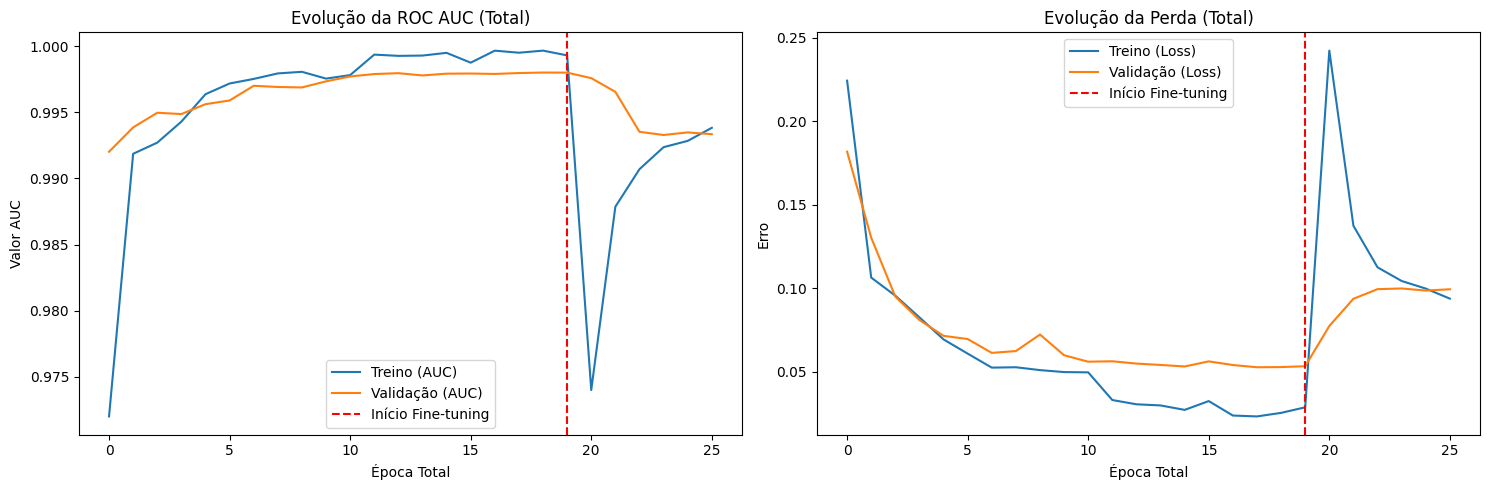

In [22]:
full_auc = history.history['auc'] + history_finetuning.history['auc']
full_val_auc = history.history['val_auc'] + history_finetuning.history['val_auc']
full_loss = history.history['loss'] + history_finetuning.history['loss']
full_val_loss = history.history['val_loss'] + history_finetuning.history['val_loss']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(full_auc, label='Treino (AUC)')
plt.plot(full_val_auc, label='Validação (AUC)')
plt.axvline(x=len(history.history['auc'])-1, color='red', linestyle='--', label='Início Fine-tuning')
plt.title('Evolução da ROC AUC (Total)')
plt.xlabel('Época Total')
plt.ylabel('Valor AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_loss, label='Treino (Loss)')
plt.plot(full_val_loss, label='Validação (Loss)')
plt.axvline(x=len(history.history['loss'])-1, color='red', linestyle='--', label='Início Fine-tuning')
plt.title('Evolução da Perda (Total)')
plt.xlabel('Época Total')
plt.ylabel('Erro')
plt.legend()

plt.tight_layout()
plt.show()

A convergência das curvas de treino e validação, tanto antes, quanto depois do Fine-tuning, confirma que o modelo aprendeu os padrões sem realizar overfitting. Além disso, a AUC cada vez mais se aproximando de 1.0 atesta a alta confiabilidade do diagnóstico.

Como estatística final, também mostramos a matriz de confusão para identificar onde o modelo falha. Apesar da nossa métrica padrão ser a ROC-AUC, modelos médicos também devem buscar reduzir o número de falsos negativos para garantir que nenhum paciente doente fique sem tratamento.

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 659ms/step


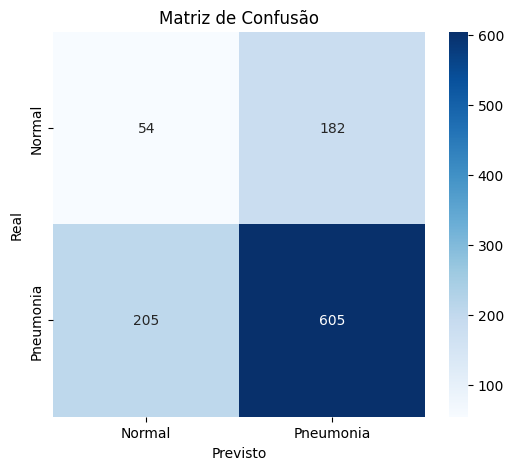

              precision    recall  f1-score   support

      Normal       0.21      0.23      0.22       236
   Pneumonia       0.77      0.75      0.76       810

    accuracy                           0.63      1046
   macro avg       0.49      0.49      0.49      1046
weighted avg       0.64      0.63      0.64      1046



In [24]:
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int)

y_true = np.concatenate([y for x, y in val_generator], axis=0).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

In [25]:
from google.colab import drive

drive.mount('/content/drive')

target_dir = '/content/drive/MyDrive/PneuModel/'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

import shutil
shutil.copy('./modelo.keras', target_dir + 'modelo.keras')
print(f"✅ Modelo salvo em {target_dir}")

Mounted at /content/drive
✅ Modelo salvo em /content/drive/MyDrive/PneuModel/


### Explicabilidade do modelo

A técnica Grad-CAM está sendo utilizada para gerar um mapa de calor sobre a imagem original. Isso destaca as áreas do pulmão que mais influenciaram a decisão da modelo.

A partir disso, podemos entender melhor se a decisão do modelo é coerente realmente e se ela pontua de fato o que é necessário para identificar a doença.

In [26]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for images, labels in val_datagen.take(1):
    img_array = images[0:1]
    img_single = images[0].numpy()
    label_real = labels[0].numpy()
    break

def get_gradcam_v3(model, img_input):
    base_model = model.get_layer("efficientnetb0")
    last_conv_layer = base_model.get_layer("top_activation")

    intermediate_model = tf.keras.Model([base_model.inputs], [last_conv_layer.output, base_model.output])

    with tf.GradientTape() as tape:
        conv_output, base_output = intermediate_model(img_input)

        x = base_output
        for layer in model.layers[1:]:
            x = layer(x)

        prediction_score = x[:, 0]

    grads = tape.gradient(prediction_score, conv_output)

    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Geração do heatmap na imagem
    conv_output = conv_output[0]
    heatmap = conv_output @ weights[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

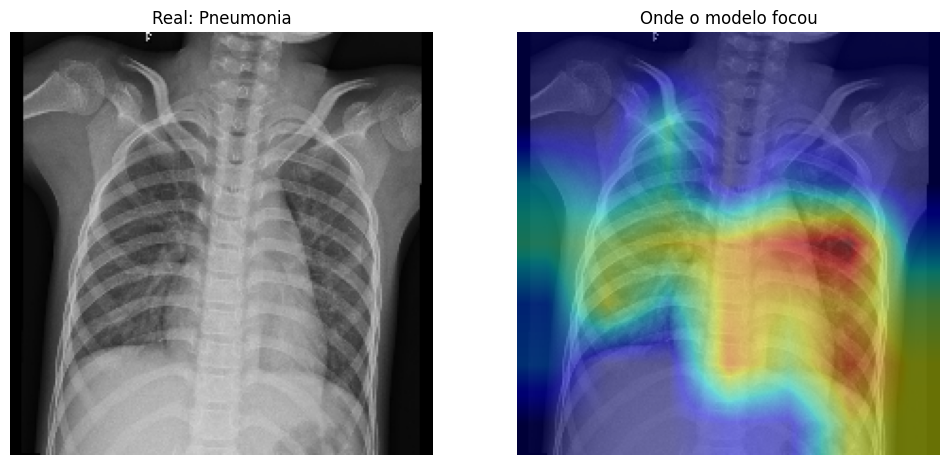

In [42]:
heatmap = get_gradcam_v3(model, img_array)

plt.figure(figsize=(12, 6))

# Imagem Original
plt.subplot(1, 2, 1)
plt.imshow(img_single.astype('uint8'))
plt.title(f"Real: {'Pneumonia' if label_real == 1 else 'Normal'}")
plt.axis('off')

# Sobreposição
plt.subplot(1, 2, 2)
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224)).numpy()
plt.imshow(img_single.astype('uint8'))
plt.imshow(heatmap_resized[..., 0], alpha=0.45, cmap='jet') # Overlay
plt.title("Onde o modelo focou")
plt.axis('off')

plt.show()